<a href="https://colab.research.google.com/github/Shahahaha11/LION_DEN/blob/main/trial_MODEL_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name map


---


trial -> trying new variable

---


data_cleaning -> a separate file which ends with saving a pickle that you use in model.ipynb


---


model -> Main model with little extra code

---


model_testing -> Less code, optimized for testing

---



In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_2 = pd.read_pickle('/content/drive/MyDrive/lions_den_data/df_2_trial.pkl')

In [ ]:
# FIRST SPLIT
n_train = int(0.8 * len(df_2))
train = df_2.iloc[:n_train]
test  = df_2.iloc[n_train:]

X_train = train.drop(columns=['latestPrice'])
y_train = train['latestPrice']
X_test = test.drop(columns=['latestPrice'])
y_test = test['latestPrice']
X_train.shape


(12016, 42)

In [ ]:
pip install mgwr

In [ ]:
print(X_train.select_dtypes(include=['object']).columns)

Index([], dtype='object')


In [ ]:
X_train.shape

(12016, 42)

In [ ]:
# GWR using mgwr library: MAIN : output -> local_betas
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

coords = X_train[['latitude', 'longitude']].values
# dropping : garageSpaces and parkingSpaces are perfectly collinear (their correlation is 1 and their VIFs are infinite)
X_ = X_train.select_dtypes(include=['number']).drop(columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces', 'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420'],
    errors='ignore'
).values

y_ = y_train.values.reshape(-1, 1)
X_gwr = np.hstack([np.ones((X_.shape[0], 1)), X_])

# using a fixed band width
fixed_bw = 0.8

gwr_model = GWR(
    coords,       # (n, 2)
    y_,           # (n, 1)
    X_gwr,        # (n, p) [including intercept]
    bw=fixed_bw,
    kernel='gaussian',  # Gaussian kernel
    fixed=True,         # fixed distance bandwidth
    spherical=False
).fit()

local_betas = gwr_model.params  # shape (n, p)
print("Local betas shape:\n", local_betas.shape)


Local betas shape:
 (12016, 31)


In [ ]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# Prepare coordinates
coords = X_train[['latitude', 'longitude']].values

# Drop columns that cause collinearity or are not needed
X_ = X_train.select_dtypes(include=['number']).drop(
    columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces',
             'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420'],
    errors='ignore'
).values

y_ = y_train.values.reshape(-1, 1)

# Add the intercept
X_gwr = np.hstack([np.ones((X_.shape[0], 1)), X_])

# -------------------------------------------------------------
# 1. Use Sel_BW to find the best fixed bandwidth automatically,
#    but set a minimum bw to avoid singular local regressions.
# -------------------------------------------------------------
selector = Sel_BW(
    coords,
    y_,
    X_gwr,
    kernel='gaussian',
    fixed=True
)

best_bw = selector.search(
    criterion='AICc',
    min_bw=0.3,  # Adjust based on your data scale
    max_bw=1.5   # Optional upper limit
)
print("Optimal fixed bandwidth found:", best_bw)

# ----------------------------------------------------------------
# 2. Fit the GWR model using the optimal bandwidth
# ----------------------------------------------------------------
gwr_model = GWR(
    coords,
    y_,
    X_gwr,
    bw=best_bw,
    kernel='gaussian',
    fixed=True,
    spherical=False
).fit()

local_betas = gwr_model.params
print("Local betas shape:\n", local_betas.shape)


TypeError: Sel_BW.search() got an unexpected keyword argument 'min_bw'

In [ ]:
# SECOND TRIAL, MORE COMPLEX
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import warnings

coords = X_train[['latitude', 'longitude']].values

X_ = X_train.select_dtypes(include=['number']).drop(
    columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces',
             'MORTGAGE30US', 'MEDLISPRIPERSQUFEE12420'],
    errors='ignore'
).values

y_ = y_train.values.reshape(-1, 1)

# Add the intercept
X_gwr = np.hstack([np.ones((X_.shape[0], 1)), X_])

# You can pick your own range (start, end) and granularity for the grid.
bandwidth_candidates = np.linspace(0.3, 0.5)  # e.g., 30 steps from 0.5 to 10

best_bw = None
best_aicc = np.inf

for bw in bandwidth_candidates:
    try:
        # Fit the GWR for each candidate bandwidth
        gwr_temp = GWR(
            coords,
            y_,
            X_gwr,
            bw=bw,
            kernel='gaussian',
            fixed=True,
            spherical=False
        ).fit()

        # Compare AICc for selecting the best
        if gwr_temp.aicc < best_aicc:
            best_aicc = gwr_temp.aicc
            best_bw = bw
    except (np.linalg.LinAlgError, ValueError) as e:
        # Singular matrix or invalid solution for some bandwidth
        warnings.warn(f"Skipping bw={bw} due to error: {e}")
        continue

print(f"Chosen bandwidth: {best_bw}, with AICc: {best_aicc}")

# Now refit with the best bw you found
gwr_model = GWR(
    coords,
    y_,
    X_gwr,
    bw=best_bw,
    kernel='gaussian',
    fixed=True,
    spherical=False
).fit()

local_betas = gwr_model.params
print("Local betas shape:\n", local_betas.shape)


In [ ]:
############################################### Random Forest with Local Slopes #################################################
# MODEL 0 "USING local_betas" "no parameter tuning"

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Why did we remove from X_train?
# latitude & longitude -> used by GWR
# latest_saledate -> used for sorting, we have already dynamically incorporated time dependence using other variables
# parkingSpaces -> Perfect collinearity with Garage spaces

X_rf = X_train.select_dtypes(include=['number']).drop(
    columns=['latitude', 'longitude', 'latest_saledate', 'parkingSpaces'],
    errors='ignore'
).values
print("X_rf shape:", X_rf.shape)

# local_betas are obtained from the GWR model; its shape is (n, p).
local_betas = gwr_model.params
print("local_betas shape:", local_betas.shape)

# local_slopes are defined by dropping the intercept column (first column) from local_betas.
# This gives us an array of shape (n, p-1).
local_slopes = local_betas[:, 1:]

X_aug = np.hstack([X_rf, local_slopes])
print("Augmented feature shape:", X_aug.shape)

y_array = y_.ravel()

n_total = X_aug.shape[0]
n_train = int(0.8 * n_total)

X_train_aug = X_aug[:n_train]
y_train_rf = y_array[:n_train]
X_valid_aug = X_aug[n_train:]
y_valid_rf = y_array[n_train:]

rf = RandomForestRegressor(
    n_estimators=200,
    max_features='sqrt',
    random_state=11,
    n_jobs=-1
)

rf.fit(X_train_aug, y_train_rf)
y_pred = rf.predict(X_valid_aug)

# Evaluation
r2 = r2_score(y_valid_rf, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid_rf, y_pred))

print("Random Forest Performance:")
print(f"  R^2:  {r2:.3f}")
print(f"  RMSE: {rmse:,.3f}")


X_rf shape: (12016, 32)
local_betas shape: (12016, 31)
Augmented feature shape: (12016, 62)
Random Forest Performance:
  R^2:  0.707
  RMSE: 228,795.316


In [ ]:
train_dates = train['latest_saledate'].values
# Chronological split on the RF data (which comes from the training set)
n_rf_total = X_aug.shape[0]    # Should match len(train_dates)
n_rf_train = int(0.8 * n_rf_total)

X_train_aug = X_aug[:n_rf_train]
y_train_rf = y_array[:n_rf_train]
X_valid_aug = X_aug[n_rf_train:]
y_valid_rf = y_array[n_rf_train:]

rf_test_dates = train_dates[n_rf_train:]


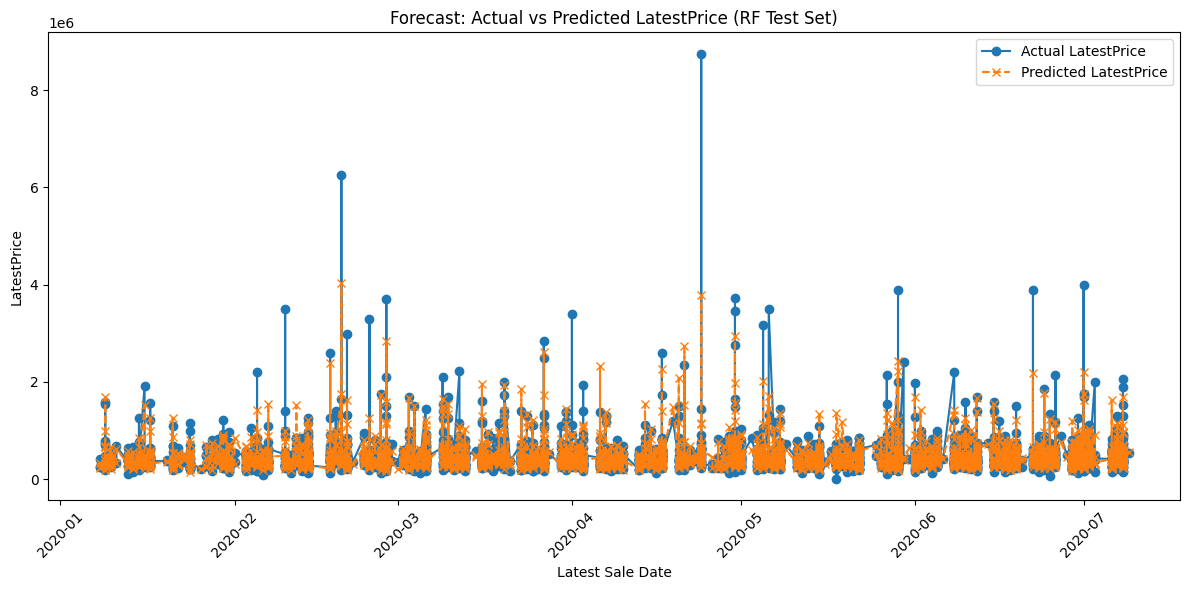

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(rf_test_dates, y_valid_rf, label='Actual LatestPrice', marker='o', linestyle='-')
plt.plot(rf_test_dates, y_pred, label='Predicted LatestPrice', marker='x', linestyle='--')
plt.xlabel('Latest Sale Date')
plt.ylabel('LatestPrice')
plt.title('Forecast: Actual vs Predicted LatestPrice (RF Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
##### THIS IS NOT FOR BEST PARAMETERS ####### NOT A COPY ################### MODEL PERFORMANCE EVALUATION ########################################################################

# Predict on the training and validation sets using the correct variables.
y_train_pred = rf.predict(X_train_aug)
y_valid_pred = rf.predict(X_valid_aug)

# Compute R² scores.
train_r2 = r2_score(y_train_rf, y_train_pred)
valid_r2 = r2_score(y_valid_rf, y_valid_pred)

# Compute RMSE scores.
train_rmse = np.sqrt(mean_squared_error(y_train_rf, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid_rf, y_valid_pred))

# Print training metrics.
print("Training Metrics:")
print(f"  R²:   {train_r2:.3f}")
print(f"  RMSE: {train_rmse:,.3f}")

# Print validation metrics.
print("\nValidation Metrics:")
print(f"  R²:   {valid_r2:.3f}")
print(f"  RMSE: {valid_rmse:,.3f}")


Training Metrics:
  R²:   0.947
  RMSE: 104,456.753

Validation Metrics:
  R²:   0.697
  RMSE: 232,693.472


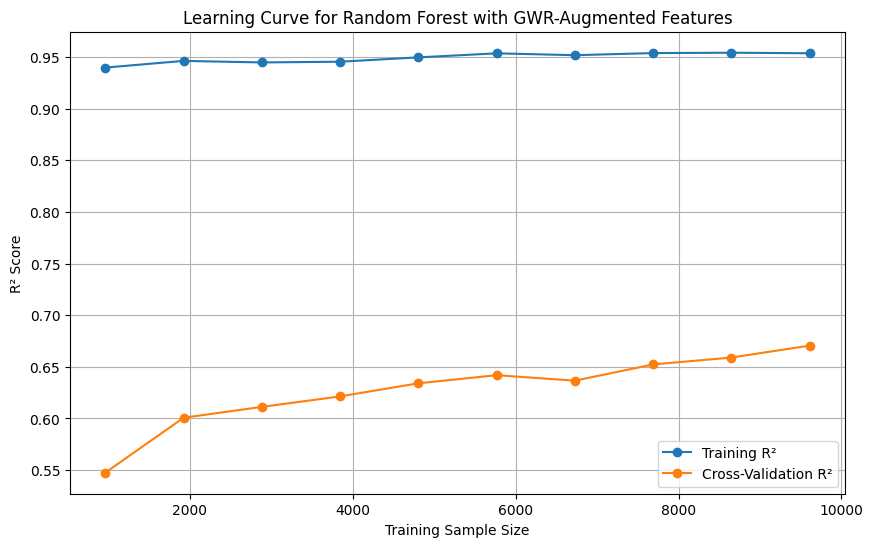

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# COMPUTE LEARNING CURVE
train_sizes, train_scores, valid_scores = learning_curve(
    estimator= rf,
    X=X_aug,
    y=y_array.ravel(),
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=11
)

# Calculate the mean scores across the folds
mean_train_scores = np.mean(train_scores, axis=1)
mean_valid_scores = np.mean(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training R²')
plt.plot(train_sizes, mean_valid_scores, 'o-', label='Cross-Validation R²')
plt.xlabel('Training Sample Size')
plt.ylabel('R² Score')
plt.title('Learning Curve for Random Forest with GWR-Augmented Features')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_2.columns

Index(['latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'parkingSpaces', 'yearBuilt', 'latestPrice',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'numOfPhotos', 'numOfAccessibilityFeatures',
       'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'MORTGAGE30US',
       'MEDLISPRIPERSQUFEE12420'],
      dtype='object')